# Создание прототипа модели машинного обучения, предсказывающей коэффициент восстановления золота из золотосодержащей руды, для конмании "Цифра"
В этой работе мы выберем наилучшую модель машинного обучения, которая предсказывает коэффициент восстановления золота из золотосодержащей руды.
# Содержание
## [Проверка расчета rougher.output.recovery](#step_1)
### [Комментарий](#step_2)
## [Выделение признаков](#step_3)
### [Комментарий](#step_4)
## [Изменение концентрации веществ на этапах](#step_5)
### [Выводы](#step_6)
## [Распределение размера гранул на тестовой и обучающей выборках](#step_7)
### [Выводы](#step_8)
## [Изучение нулевых знчений](#step_9)
### [Обзор результатов](#step_10)
## [Обучение моделей](#step_11)
### [Модели для final](#step_11)
#### [Промежуточные результаты](#step_12)
### [Модели для rougher](#step_13)
#### [Промежуточные результаты](#step_14)
## [Проверка моделей на тестовой выборке](#step_15)
### [Результаты](#step_16)

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle

In [8]:
try:
    full_df = pd.read_csv('/Users/semionkaminsky/Desktop/YP/United 2/gold_recovery_full.csv')
    train_df = pd.read_csv('/Users/semionkaminsky/Desktop/YP/United 2/gold_recovery_train.csv')
    test_df = pd.read_csv('/Users/semionkaminsky/Desktop/YP/United 2/gold_recovery_test.csv')
except:
    full_df = pd.read_csv('/datasets/gold_recovery_full.csv')
    train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
    test_df = pd.read_csv('/datasets/gold_recovery_test.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


## Проверка расчета rougher.output.recovery
<a id='step_1'></a>

In [9]:
def drop(df, column, inplace):
    df.drop(train_df[train_df[column].isna()].index, inplace = inplace)
def show(df, head = 5, print_ = False):
    display(df.head(head))
    if print_: print(df.info())
def recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    try:
        au_recovery = (c*(f-t)) / (f*(c-t)) * 100
    except:
        au_recovery = np.nan
    return au_recovery
def fill(df):
    for column in df.columns:
        if df[column].isna().sum() > 0:
            df[column].fillna(method = 'ffill', inplace = True)
    return df

In [10]:
drop(train_df, 'final.output.recovery', inplace = True)
drop(train_df, 'rougher.output.recovery', inplace = True)

drop(full_df, 'final.output.recovery', inplace = True)
drop(full_df, 'rougher.output.recovery', inplace = True)

train_df = fill(train_df)
full_df = fill(full_df)
test_df = fill(test_df)
train_df['recovery_calculated'] = train_df.apply(recovery, axis = 1)
print('MAE между рассчетным и данным значениями recovery равна ', mae(train_df['rougher.output.recovery'], train_df['recovery_calculated']))
train_df.info()

MAE между рассчетным и данным значениями recovery равна  9.317053768151204e-15
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14149 non-null  float64
 2   final.output.concentrate_pb                         14149 non-null  float64
 3   final.output.concentrate_sol                        14149 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14149 non-null  float64
 8

### Выводы и комментарии
<a id='step_2'></a>
Итак, полет нормальный MAE близка к 0. Не равна, скорее всего, из-за округлений, но -15 степень - это ерундовое значение.
Шаги:
- Удалили все пропущенные значения из наших будущих таргетов. Оставить их или заполнить значит в будущем учить модель неправильно. Потеряли порядка 10%, что конечно плохо, но лучше, чем trash-in-trash-out.
- Пропуски в остальных столбцах заполнили методом 'ffill'.
- Рассчитали коэффициент восставновления после флотации.

## Выделение faetures 
<a id='step_3'></a>
Необходимо рассмотреть столбцы `train_df`, недоступные в `test_df`. Это позволит нам выделить features для последующего обучения моделей.

In [11]:
display(train_df.drop(pd.Series(test_df.columns), axis = 1).columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

### Комментарии
<a id='step_4'></a>
1. Первое, что бросается в глааза, - output-ы. Вполне логично, что во вводных данных могут быть только input-ы (концентрации металлов, отвальные хвосты). На то они и вводные :)
2. Также, нет части рассчитываемых признаков с пометкой `calculation`. 
Итак, в `features` идут все названия столбцов из тестовой выборки, а в `target` пойдут `rougher.output.recovery` и `final.output.recovery`.

In [12]:
features_names = test_df.columns
target_names = ['rougher.output.recovery', 'final.output.recovery']

## Анализ изменения концентрации веществ на различных этапах
<a id='step_5'></a>

In [13]:
def concentration(df, metal):
    a = df['rougher.input.feed_' + metal]
    b = df['rougher.output.concentrate_' + metal]
    c = df['primary_cleaner.output.concentrate_' + metal]
    d = df['final.output.concentrate_' + metal]
    fig = plt.figure()
    labels= ['Сырье','После флотации', 'После 1 очистки', 'Финальный концентрат']
    ax = fig.add_subplot(111)
    ax.hist(a, alpha = 0.6, bins = 15)
    ax.hist(b, alpha = 0.6, bins = 15)
    ax.hist(c, alpha = 0.6, bins = 15)
    ax.hist(d, alpha = 0.6, bins = 15)
    ax.legend(labels)
    ax.set(title = metal)
    plt.show()

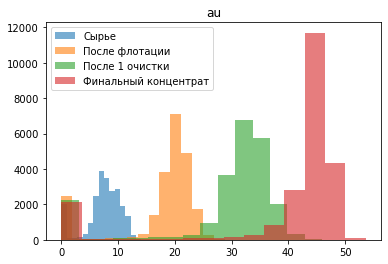

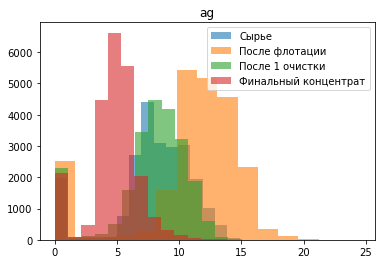

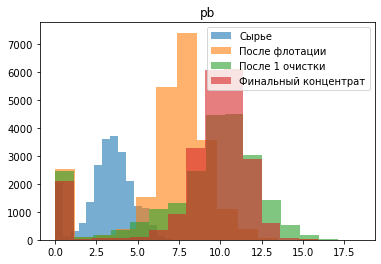

In [14]:
concentration(full_df, 'au')
concentration(full_df, 'ag')
concentration(full_df, 'pb')

### Результаты анализа
<a id='step_6'></a>
1. Интересно, что на всех этапах есть наблюдения с нулевой концентрацией. Разберемся с этой аномалией позднее.
1. Концентрация золота, как и предполагалось, увеличивается с самыми большими темпами: разница между этапами существенна, изменение распределений концентрации отчетливо видно.
2. Концентрация серебра в результате очистки уменьшается. Однако после флотации увеличивается. Видимо, имеет место специфика воздействия различных этапов обработки руды на серебро.
3. Концентрация свинца увеличивается, но не критически: заметный рост после флотации, а очистка дает лишь небольшой рост. Опять же, специфика технологического процесса.

##  Анализ распределений размера гранул на тестовой и обучающей выборке
<a id='step_7'></a>

Text(0.5, 1.0, 'Сравнение распределений размера гранул на тестовой и обучающей выборках')

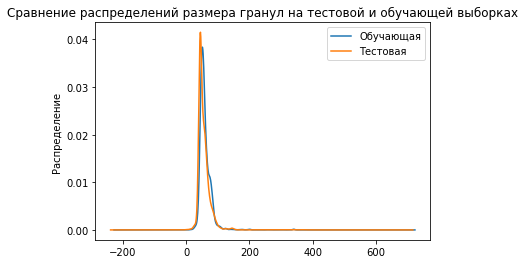

In [15]:
train_df['rougher.input.feed_size'].plot.kde()
test_df['rougher.input.feed_size'].plot.kde()
plt.legend(['Обучающая', 'Тестовая'])
plt.ylabel('Распределение')
plt.title('Сравнение распределений размера гранул на тестовой и обучающей выборках')

### Вывод
<a id='step_8'></a>
Как видим, распределения приблизительно одинаковые, то есть входные данные тестовой и обучающей выборок, скажем, "однородны". Поэтому можем предполагать, что обучение имеет смысл.

## Изучение аномальных значений
<a id='step_9'></a>
На самом деле, мы уже раньше могли обращать внимание на наличие "нулевых строк". Посмотрим на них внимательнее.

In [16]:
def sum_concentrations(row):
    things = ['pb', 'au', 'ag', 'sol']
    stages = ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
    sums = pd.DataFrame()
    for stage in stages:
        concent_sum = 0
        for thing in things:
            concent_sum += row[stage + thing]
        sums[str(stage)] = concent_sum
    return sums

In [17]:
train_df = train_df.merge(sum_concentrations(train_df), right_index = True, left_index = True)
test_df['rougher.input.feed_'] = test_df['rougher.input.feed_au'] + test_df['rougher.input.feed_ag'] + test_df['rougher.input.feed_pb'] + test_df['rougher.input.feed_sol']

stages = ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
threshold = 0.3

for stage in stages:
    print('Для тестовой выборки на этапе', stage, 'с пороговым значением', threshold, 'аномальных значений:', train_df[train_df[stage] < threshold]['date'].count())
    train_df.drop(train_df[train_df[stage] < threshold].index, inplace = True)
    print('Удаляем!')

print('Для тестовой выборки на этапе флотации с пороговым значением', threshold, 'аномальных значений:', test_df[test_df['rougher.input.feed_'] < threshold]['date'].count())
test_df.drop(test_df[test_df['rougher.input.feed_'] < threshold].index, inplace = True)
print('Удаляем!')

Для тестовой выборки на этапе rougher.input.feed_ с пороговым значением 0.3 аномальных значений: 5
Удаляем!
Для тестовой выборки на этапе rougher.output.concentrate_ с пороговым значением 0.3 аномальных значений: 297
Удаляем!
Для тестовой выборки на этапе primary_cleaner.output.concentrate_ с пороговым значением 0.3 аномальных значений: 190
Удаляем!
Для тестовой выборки на этапе final.output.concentrate_ с пороговым значением 0.3 аномальных значений: 57
Удаляем!
Для тестовой выборки на этапе флотации с пороговым значением 0.3 аномальных значений: 371
Удаляем!


### Результаты
<a id='step_10'></a>
Итак, мы обнаружили эти "нулевые аномалии" и в тестовом, и в обучающем датасетах. Вероятно, их природа кроется в технических сбоях оборудования. Вряд ли получится выявить какую-то полезную информацию из них, поэтому решили все удалить.

## Обучение моделей
### Модель для предсказания final.output.recovery
<a id='step_11'></a>

In [18]:
def scorer(target, predictions):
    score = abs(predictions - target) / (0.5 * (abs(target) + abs(predictions)))
    return score.mean() * 100
my_scorer = make_scorer(scorer, greater_is_better = False)

In [19]:
# СОЗДАНИЕ ПУСТЫХ МОДЕЛЕЙ И КЛАССОВ СЛУЧАЙНОГО ПОИСКА
tree_final = DecisionTreeRegressor(random_state = 12345)
forest_final = RandomForestRegressor(random_state = 12345)
best_lreg_final = LinearRegression(normalize = False)
tree_grid_final = {'max_depth': range(1, 10)}
forest_grid_final = {'max_depth': range(1, 10), 'n_estimators': range(1, 100, 10)}
best_tree_final = RandomizedSearchCV(tree_final, n_jobs = -1, n_iter = 9, param_distributions = tree_grid_final, random_state = 12345, scoring = my_scorer, cv = 5)
best_forest_final = RandomizedSearchCV(forest_final, n_jobs = -1, n_iter = 9, param_distributions = forest_grid_final, random_state = 12345, scoring = my_scorer, cv = 5)

# ПОДГОТОВКА ПРЗНАКОВ, ВЫДЕЛЕНИЕ ЦЕЛЕВЫХ ХАРАКТЕРИСТИК
features_train_final = train_df[features_names].drop('date', axis = 1)
target_train_final = train_df['final.output.recovery']
scaler_final = StandardScaler()
features_train_final_scaled = scaler_final.fit_transform(features_train_final)

In [20]:
tree_score_final = cross_val_score(best_tree_final, features_train_final, target_train_final, cv = 3, scoring = my_scorer, n_jobs = -1)
print('Среднее значение sMAPE для решающего дерева равно', abs(tree_score_final).mean())
lreg_score_final = cross_val_score(best_lreg_final, features_train_final_scaled, target_train_final, cv = 3, scoring = my_scorer, n_jobs = -1)
print('Среднее значение sMAPE для линейной регерссии равно', abs(lreg_score_final).mean())
forest_score_final = cross_val_score(best_forest_final, features_train_final, target_train_final, cv = 3, scoring = my_scorer, n_jobs = -1)
print('Среднее значение sMAPE для случайного леса равно', abs(forest_score_final).mean())

Среднее значение sMAPE для решающего дерева равно 11.090720743276988
Среднее значение sMAPE для линейной регерссии равно 13.600836515168027
Среднее значение sMAPE для случайного леса равно 10.945901687371604


In [21]:
# ОБУЧЕНИЕ МОДЕЛЕЙ И ПОЛУЧЕНИЕ ГИПЕРПАРАМЕТРОВ
best_tree_final.fit(features_train_final, target_train_final)
print('Гиперпараметры решающего дерева:', best_tree_final.best_params_)

best_forest_final.fit(features_train_final, target_train_final)
print('Гиперпараметры случайного леса:', best_forest_final.best_params_)

best_lreg_final.fit(features_train_final_scaled, target_train_final)

Гиперпараметры решающего дерева: {'max_depth': 3}
Гиперпараметры случайного леса: {'n_estimators': 91, 'max_depth': 4}


LinearRegression()

#### Промежуточные результаты
<a id='step_12'></a>
Итак, мы получили три модели машинного обучения. 
1. Для подбора гиперпараметров использовалась модель случайного поиска RandomizedSearchCV
2. Чтобы оценить результаты ее работы, мы воспользовались кросс-валидацией, обратившись к cross_val_score.
3. Лучшую оценку получила модель случайного леса (10.93) с гиперпараметрами `n_estimators = 91` и `max_depth = 4`
4. Решающее дерево отстало совсем немного, а вот линейная регресиия значительно "сдает"

###  Модель для предсказания rougher.output.recovery
<a id='step_13'></a>

In [22]:
# СОЗДАНИЕ ПУСТЫХ МОДЕЛЕЙ И КЛАССОВ СЛУЧАЙНОГО ПОИСКА
tree_rougher = DecisionTreeRegressor(random_state = 12345)
forest_rougher = RandomForestRegressor(random_state = 12345)
best_lreg_rougher = LinearRegression(normalize = False)
tree_grid_rougher = {'max_depth': range(1, 10)}
forest_grid_rougher = {'max_depth': range(1, 10), 'n_estimators': range(1, 100, 10)}
best_tree_rougher = RandomizedSearchCV(tree_rougher, n_jobs = -1, n_iter = 9, param_distributions = tree_grid_rougher, random_state = 12345, scoring = my_scorer, cv = 5)
best_forest_rougher = RandomizedSearchCV(forest_rougher, n_jobs = -1, n_iter = 9, param_distributions = forest_grid_rougher, random_state = 12345, scoring = my_scorer, cv = 5)

# ПОДГОТОВКА ПРЗНАКОВ, ВЫДЕЛЕНИЕ ЦЕЛЕВЫХ ХАРАКТЕРИСТИК
features_names_rougher = []
for column in test_df.columns:
    if 'rougher.input' in column:
        features_names_rougher.append(column)
    elif 'rougher.state' in column:
        features_names_rougher.append(column)

features_names_rougher.remove('rougher.input.feed_')
features_train_rougher = train_df[features_names_rougher]
target_train_rougher = train_df['rougher.output.recovery']

scaler_rougher = StandardScaler()
features_train_rougher_scaled = scaler_rougher.fit_transform(features_train_rougher)

In [23]:
tree_score_rougher = cross_val_score(best_tree_rougher, features_train_rougher, target_train_rougher, cv = 3, scoring = my_scorer, n_jobs = -1)
print('Среднее значение sMAPE для решающего дерева равно', abs(tree_score_rougher).mean())
lreg_score_rougher = cross_val_score(best_lreg_rougher, features_train_rougher_scaled, target_train_rougher, cv = 3, scoring = my_scorer, n_jobs = -1)
print('Среднее значение sMAPE для линейной регерссии равно', abs(lreg_score_rougher).mean())
forest_score_rougher = cross_val_score(best_forest_rougher, features_train_rougher, target_train_rougher, cv = 3, scoring = my_scorer, n_jobs = -1)
print('Среднее значение sMAPE для случайного леса равно', abs(forest_score_rougher).mean())

Среднее значение sMAPE для решающего дерева равно 8.831636317496743
Среднее значение sMAPE для линейной регерссии равно 9.066419157735407
Среднее значение sMAPE для случайного леса равно 8.408190506518743


In [24]:
#ОБУЧЕНИЕ МОДЕЛЕЙ
best_tree_rougher.fit(features_train_rougher, target_train_rougher)
print('Гиперпараметры решающего дерева:', best_tree_rougher.best_params_)
best_forest_rougher.fit(features_train_rougher, target_train_rougher)
print('Гиперпараметры случайного леса:', best_forest_rougher.best_params_)
best_lreg_rougher.fit(features_train_rougher_scaled, target_train_rougher)

Гиперпараметры решающего дерева: {'max_depth': 5}
Гиперпараметры случайного леса: {'n_estimators': 21, 'max_depth': 7}


LinearRegression()

#### Промежуточные результаты
<a id='step_14'></a>
Мы снова получили три модели машинного обучения, которые в этот раз предсказывают значение `rougher.output.recovery`. 
1. Лучшую оценку получила модель случайного леса (8.4) с гиперпараметрами `n_estimators = 21` и `max_depth = 7`
2. На самом деле, и линейная регрессия, и решающее дерево отстают незначительно

Что же, пришло время проверить все наши модели на тестовой выборке.

## Проверка моделей на тестовой выборке
<a id='step_15'></a>

In [25]:
# ПЕРЕНЕСЕНИЕ ЦЕЛЕВЫХ ПРИЗНАКОВ В ТЕСТОВУЮ ВЫБОРКУ
dates = list(test_df['date'])
target_test = full_df.query('date in @dates')[['date', 'rougher.output.recovery', 'final.output.recovery']]
test_df = test_df.merge(target_test, on = 'date')
# РАЗБИЕНИЕ И СТАНДАРТИЗАЦИЯ
target_test_final = test_df['final.output.recovery']
features_test_final = test_df[features_names].drop('date', axis = 1)
features_test_scaled_final = scaler_final.transform(features_test_final)

target_test_rougher = test_df['rougher.output.recovery']
features_test_rougher = test_df[features_names_rougher]
features_test_scaled_rougher = scaler_rougher.transform(features_test_rougher)

In [26]:
def smape(estimator_final, estimator_rougher, features_final, features_rougher, target_final, target_rougher):
    predictions_final = estimator_final.predict(features_final)
    predictions_rougher = estimator_rougher.predict(features_rougher)
    smape_rougher = scorer(target_rougher, predictions_rougher)
    smape_final = scorer(target_final, predictions_final)
    result = 0.75 * smape_final + 0.25 * smape_rougher
    return result    

In [27]:
result_tree = smape(best_tree_final, best_tree_rougher, features_test_final, features_test_rougher, target_test_final, target_test_rougher)
result_forest = smape(best_forest_final, best_forest_rougher, features_test_final, features_test_rougher, target_test_final, target_test_rougher)
result_lreg = smape(best_lreg_final, best_lreg_rougher, features_test_scaled_final, features_test_scaled_rougher, target_test_final, target_test_rougher)
print('Итоговый sMAPE решающего дерева равен', result_tree)
print('Итоговый sMAPE случайного леса равен', result_forest)
print('Итоговый sMAPE линейной регресии равен', result_lreg)

median_final = target_train_final.median()
median_rougher = target_train_rougher.median()
median_predictions_final = pd.Series(data = median_final, index = features_test_final.index)
median_predictions_rougher = pd.Series(data = median_rougher, index = features_test_rougher.index)
result_median = scorer(target_test_final, median_predictions_final) * 0.75 + scorer(target_test_rougher, median_predictions_rougher)*0.25
print('Итоговый sMAPE медианного предсказания равен', result_median)

Итоговый sMAPE решающего дерева равен 10.722628312364279
Итоговый sMAPE случайного леса равен 10.579453410568714
Итоговый sMAPE линейной регресии равен 10.43778591423812
Итоговый sMAPE медианного предсказания равен 10.58752261777591


## Результат
<a id='step_16'></a>
Сначала кратко опишем, что мы сделали на последнем этапе.
1. "Подтянули" target-ы из полного датасета
2. Стандартизировали их features с помощью модели StandardScaler, ранее обученной на тренировочном датасете
3. Написали функцию для расчета итогового sMAPE
4. Посчитали все показатели
5. Для оценки адекватности сравнили с медианным предсказанием 

И что же в итоге?

Ура, две модели прошли проверку на адекватность проверку адекватность: случайный лес и линейная регрессия. Притом именно линейная регрессия стала лучшей!

Если быть до конца откровенными, мы должны признать, что все различия незначительны и, если датасет будет немного отличаться, то результат может измениться в плоть до "неадекватности" всех моделей. Уже сейчас можно сказать, что медианная модель может быть выбрана в качестве лучшей, как минимум, по скорости работы. Возможно, это связано с недостаточно "чистыми" данными. Или недостаточным их объемом. В любом случае, дело в данных, поэтому нужно покопаться в способах их сбора.